In [1]:
from pymongo import MongoClient
from elasticsearch import Elasticsearch
from basic.claims import connect #, get_claims, get_users, get_kibana_gate, products_bankiros, nulls, get_medium, get_claims_raw
# from basic.external import cpa_parse, get_yandex_data
# from basic.dscore import cre_get, mfo_score
from basic.reports import cre_keyword_report, master_report, registrations_medium
from basic.vars import regions_mapper, claim_offers
from bson.objectid import ObjectId
import requests
import json
from datetime import datetime, date, timedelta
import pandas as pd
from time import sleep
from base64 import b64encode
import numpy as np
# from robobrowser import RoboBrowser
import re
# import csv, sqlite3
# import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns
from calendar import monthrange
import pickle
import os.path
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from googleapiclient.discovery import build
from dateutil.relativedelta import relativedelta
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth',1000)
# from IPython.display import Filelink, FileLinks


client, es = connect()

/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Доспуп к Эластику 	 True
Доспуп к Монге 		 True


In [2]:
#!pip install robobrowser

In [3]:
# !pip install pickledb pymongo elasticsearch==6.8 oauth2client gspread df2gspread \
# robobrowser beautifulsoup4 lxml yourls Werkzeug==0.16.1 paramiko xlsxwriter pyminizip \
# html5lib zodiac_sign python-pptx plotly df2gspread gspread

In [4]:
def gsheet_api_check(SCOPES):
    creds = None
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)    
            
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'credentials.json', SCOPES)  # сюда json файл если он не в той же папке
            creds = flow.run_local_server(port=0)        
            
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)    
    return creds

def pull_sheet_data(SCOPES,SPREADSHEET_ID,RANGE_NAME):
    creds = gsheet_api_check(SCOPES)
    service = build('sheets', 'v4', credentials=creds)
    sheet = service.spreadsheets()
    result = sheet.values().get(
        spreadsheetId=SPREADSHEET_ID,
        range=RANGE_NAME).execute()
    values = result.get('values', [])
    
    if not values:
        print('No data found.')
    else:
        rows = sheet.values().get(spreadsheetId=SPREADSHEET_ID,
                                  range=RANGE_NAME).execute()
        data = rows.get('values')
        print("COMPLETE: Data copied")
        return data
    
def to_float(x):
    try:
        return(float(x.replace("\xa0", '').replace(" ", '').strip()))
    except Exception as e:
        return np.nan

In [5]:
def cre_get(es, since):
    
    chunk = 10000
    gte = (str(datetime.combine(since, datetime.min.time()).timestamp()).replace(".", "")+"0000000")[:13]
    payload = {"size": chunk,
               "_source": ["params.parsed"],
"query":{"bool":{"must":[{"match_all":{}},
                         {"match_phrase":{"eventType.keyword": "CRE"}},
                         {"range":{"timestamp":{"gte":gte,"format":"epoch_millis"}}}
                        ]}},
"_source": ["params.parsed", "timestamp"]
              }
    
    d = es.search(index='events', doc_type='event', body=payload, scroll='120m', request_timeout=3000)
    sleep(0.5)
    doc_count = d['hits']['total']
    hits = d['hits']['hits']
    print(doc_count, end ="; ", flush=True)
    res = []
    for i in range(1, int(doc_count/chunk)+1):
        scroll = d['_scroll_id']
        d = es.scroll(scroll_id = scroll, scroll = '120m', request_timeout=3000)
        hits = hits + d['hits']['hits']
        print(doc_count-chunk*i, end ="; ", flush=True)
        sleep(0.5)
#         break
    print(len(hits), 'raz')
    cre = []
    for h in hits:
        if len(h['_source']['params']['parsed'])>10:
            h2 = json.loads(h['_source']['params']['parsed'].replace("'", '"'))
            h2.update({"timestamp": pd.to_datetime(h['_source']['timestamp'])})
            cre.append(h2)
    df = pd.DataFrame(cre).sort_values("timestamp", 
                                       ascending=False).drop_duplicates('userId', keep='first').reset_index(drop=True)
    df.index = df['userId']
      
            
    return df['score'].to_dict()

In [6]:
def mm_requestId(x):
    if type(x)==dict and 'NOTE' in x.keys():
        if x['NOTE'].find('HTTP_RESPONSE_BODY') >0:
            htr = json.loads(x['NOTE'][x['NOTE'].find('HTTP_RESPONSE_BODY')+20:])
            htr = htr['requestId'] if 'requestId' in htr.keys() else np.nan
#             print(htr)
        else: 
            htr = np.nan
    else: 
        htr = np.nan
    return htr

In [7]:
def get_exact_claims(since, till, client):
    req = {"createdAt": {"$gte": datetime.combine(since, datetime.min.time()) - timedelta(hours=3),
                          "$lt": datetime.combine(till, datetime.min.time())- timedelta(hours=3)},
#            "product._id": {"$in": [ObjectId("5e9846be79dd27000141f476"),
# ObjectId("5ef4473acf22a90001010445")]},
           #"product._id": {"$in": [ObjectId(product) for product in products]}}
            "status": {"$nin": [ "ERROR", "NEW"]}} 
    results_count = client['claim-service']['claims'].count_documents(req)
    # print(req)
    print(results_count)
    all_ans = []
    batch_size = 10000
    for i in range(results_count//batch_size+1):
        ans = list(client['claim-service']['claims'].find(req, {"product": 1, "partner":1,
                                                                "borrower": 1, "statusFields":1,
                                                                "status": 1, "adapterName": 1,
                                                                "createdAt": 1, 'type':1,
                                                                "updatedAt":1, "clickId": 1,
                                                                "whence":1}).limit(batch_size).skip(i*batch_size))
        all_ans = all_ans + ans
    #ans = trans(all_ans, client)
    df = pd.DataFrame(all_ans)
    df['id'] = df["_id"].apply(lambda x: str(x))
    df['dt'] = df["createdAt"].apply(lambda x: (x+timedelta(hours=3)).date())
    df['productId'] = df['product'].apply(lambda x: str(x['_id']))
    df['product_type'] = df['product'].apply(lambda x: x['productType'] if 'productType' in x.keys() else np.nan)
    df['product_name'] = df['product'].apply(lambda x: x['name'])
    df['partner'] = df['partner'].apply(lambda x: x['name'])
    df['userId'] = df['borrower'].apply(lambda x: x['userId'])
    df['phone'] = df['borrower'].apply(lambda x: x['phone'] if 'phone' in x.keys() else np.nan)

    return df


def get_kibana_claims(es, since,till):
    gte = (str(datetime.combine(since, datetime.min.time()).timestamp()).replace(".", "")+"0000000")[:13]
    lt = (str(datetime.combine(till, datetime.min.time()).timestamp()).replace(".", "")+"0000000")[:13]

    payload = {"size": 10000,
"query":{"bool":{"must":[{"match_all":{}},
                         {"match_phrase":{"eventType.keyword":"CLAIM"}},
#                          {"match_phrase":{"params.sourceGlobal.keyword":{"query": sourceGlobal }}},
                         {"range":{"timestamp":{"gte":gte,"lt":lt,"format":"epoch_millis"}}}]}}}
    
    d = es.search(index='events', doc_type='event', body=payload, scroll='120m', request_timeout=300)
    sleep(0.5)
    doc_count = d['hits']['total']
    hits = d['hits']['hits']
    print(doc_count, end ="; ", flush=True)
    res = []
    for i in range(1, int(doc_count/10000)+1):
        scroll = d['_scroll_id']
        d = es.scroll(scroll_id = scroll, scroll = '120m', request_timeout=300)
        hits = hits + d['hits']['hits']
        print(doc_count-10000*i, end ="; ", flush=True)
        sleep(0.5)

    dr = pd.DataFrame([hit['_source'] for hit in hits])
    dr.params.apply(lambda x: x.keys())
    for col in ['gaId', 'userId', 'utm_campaign', 'utm_medium', 'utm_source', 'utm_term', 'productType',
                'yandexClientID', 'productId', 'whence', 'transitionId', 'partnerName', #'payout', 'status',
                  'transaction_id', 'clickId', 'sourceGlobal', 'utm_content','orderId','transactionId']:
        dr[col] = dr['params'].apply(lambda x: x[col] if col in x.keys() else np.nan)

    dr['time'] = dr['timestamp'].apply(lambda x: datetime.strptime(x[:19], '%Y-%m-%dT%H:%M:%S'))
    dr['date'] = dr['time'].apply(lambda x: (x + timedelta(seconds=3*3600)).date())
    return dr

In [8]:
def get_kibana_postback(es, since):
    gte = (str(datetime.combine(since, datetime.min.time()).timestamp()).replace(".", "")+"0000000")[:13]
    lt = (str(datetime.combine(date.today()+timedelta(days=1), datetime.min.time()).timestamp()).replace(".", "")+"0000000")[:13]

    payload = {"size": 10000,
"query":{"bool":{"must":[{"match_all":{}},
                         {"match_phrase":{"eventType.keyword":"POSTBACK"}},
#                          {"match_phrase":{"params.whence.keyword":{"query": whence }}},
                         {"range":{"timestamp":{"gte":gte,"lt":lt,"format":"epoch_millis"}}}]}}}
    
    d = es.search(index='events', doc_type='event', body=payload, scroll='120m', request_timeout=300)
    sleep(0.5)
    doc_count = d['hits']['total']
    hits = d['hits']['hits']
    print(doc_count, end ="; ", flush=True)
    res = []
    for i in range(1, int(doc_count/10000)+1):
        scroll = d['_scroll_id']
        d = es.scroll(scroll_id = scroll, scroll = '120m', request_timeout=300)
        hits = hits + d['hits']['hits']
        print(doc_count-10000*i, end ="; ", flush=True)
        sleep(0.5)

    dr = pd.DataFrame([hit['_source'] for hit in hits])
    dr.params.apply(lambda x: x.keys())
    for col in ['gaId', 'userId', 'utm_campaign', 'utm_medium', 'utm_source', 'utm_term', 'productType',
                'yandexClientID', 'productId', 'whence', 'transitionId', 'partnerName', 'payout', 'status',
                'transaction_id', 'externalId','orderId','transactionId']:
        dr[col] = dr['params'].apply(lambda x: x[col] if col in x.keys() else np.nan)

    dr['time'] = dr['timestamp'].apply(lambda x: datetime.strptime(x[:19], '%Y-%m-%dT%H:%M:%S'))
    dr['date'] = dr['time'].apply(lambda x: (x + timedelta(seconds=3*3600)).date())
    return dr

In [9]:
since = date(2021,1,1)
till = date(2021, 12,31)

In [10]:
dirrect = pd.read_csv('direct.csv')
dirrect_l = dirrect['gender'].to_list()

In [11]:
dirrect_l

[16278143502556300,
 16278294219281866,
 16278466259000959,
 160301086471818729,
 160647212654699047,
 162608230083718282,
 162661808719766712,
 162735880639522459,
 162773073694026010,
 162773925474803444,
 162775599416354788,
 162776993955329736,
 162777294278597787,
 162779772653511399,
 162780714221268210,
 162780972738471898,
 162781417823645405,
 162781614838604785,
 162781649419331837,
 162781835378599523,
 162782125431500010,
 162782331118736567,
 162782507080906093,
 162782756051977529,
 162782771090516287,
 162783013645064262,
 162783163699244375,
 162783176457324268,
 162783239965657992,
 162783315778512594,
 162783350497995772,
 162783618386327355,
 162783970391774058,
 162784030067525923,
 162784674855166880,
 1571749780363256079,
 1582727796418096523,
 1582730098876190257,
 1586429032248454289,
 1618599620632662123,
 1618753952418026551,
 1619178499808561610,
 1619345916716694252,
 1620749365761219665,
 1621402290246475245,
 1621423939388479449,
 1622457414546085657,
 162

In [12]:
df = get_exact_claims(since, till, client)
df['requestId'] = df[df['partner']=='MoneyMan']['statusFields'].apply(mm_requestId)
dpbk = get_kibana_postback(es, since)
def float_apply(x):
    try:
        return float(x)
    except ValueError:
        return None
dpbk['payout'] = dpbk['payout'].apply(float_apply)
dpbk['payout'] = dpbk.apply(lambda x: x['payout']*1.2 if x['partnerName']=='admitad' else x['payout'], axis=1)
dpbk = dpbk[dpbk['status'].isin(['APPROVED', 'approved', 'ISSUED'])].sort_values('payout').drop_duplicates('transitionId', keep='last')
dr = pd.merge(left=df, right=dpbk, left_on='id', right_on='transitionId', how='left')
dc = get_kibana_claims(es, since,till)[['clickId', 'userId', 'utm_campaign', 'utm_medium', 'utm_content', 
                                        'utm_source', 'utm_term', 'gaId', 'yandexClientID', 'sourceGlobal']]
dr = pd.merge(left=dr, right=dc[dc['clickId'].notnull()].drop_duplicates('clickId'), on='clickId', how='left')

cre = cre_get(es, since)
dr['score'] = dr['userId_x'].map(cre).fillna(0).astype(int)

dr.to_pickle(f'reports/{datetime.strftime(since, "%B")}_claimReport.pickle.gz')
dc.to_pickle(f'reports/{datetime.strftime(since, "%B")}_claims.pickle.gz')

def AR_count(score, productType, status):
    koef = 1
    check = [2200, 1700, 1100, 5500]
    ARlist = [[0.00499500499500499, 0.00305343511450382, 0.0714285714285714, 0.0], 
              [0.00380818053596615, 0.00871508379888268, 0.0768345323741007, 0.0], 
              [0.00685378590078329, 0.0136418349605457, 0.0846340617412418, 0.0053475935828877], 
              [0.0111028867505552, 0.0255610972568579, 0.0980751604032997, 0.0116279069767442], 
              [0.00938967136150235, 0.0349985043374215, 0.126042632066728, 0.0], 
              [0.0109689213893967, 0.0407338308457712, 0.140204271123491, 0.0], 
              [0.0141884222474461, 0.0514050719671008, 0.113486842105263, 0.0188679245283019], 
              [0.0150753768844221, 0.0687361419068736, 0.0743243243243243, 0.0], 
              [0.00943396226415094, 0.0415430267062315, 0.0892857142857143, 0.0],
              [0.00943396226415094, 0.0415430267062315, 0.0892857142857143, 0.0]]
    
    if score is np.nan or status in ['NEW', 'ERROR']:
        return 0
    elif score > 10 and productType == 'CASH_LOAN':
        return round(ARlist[int(round(score, -1)/10)-1][0]*check[0]*koef, 2)
    elif score > 10 and productType == 'CREDIT_CARD':
        return round(ARlist[int(round(score, -1)/10)-1][1]*check[1]*koef, 2)
    elif score > 10 and productType == 'LOAN':
#         print(score, productType, status)
        return round(ARlist[int(round(score, -1)/10)-1][2]*check[2]*koef, 2)
    elif score > 10 and productType == 'REFINANCE':
        return round(ARlist[int(round(score, -1)/10)-1][3]*check[3]*koef, 2)
    else:
        return round(ARlist[int(round(score, -1)/10)-1][0]*check[0]*koef, 2)

dr['createdAt'] = pd.to_datetime(dr['createdAt'])
# dr['payout'] = dr['payout'].astype(float)
# dr['payout'] = dr.apply(lambda row: 3800 if row['partner']=='Альфа-Банк' 
#                         else row['payout'], axis=1)
# dr['payout'] = dr.apply(lambda row: 2550 if row['partner']=='Kredito24' 
#                         else row['payout'], axis=1)
# dr['productType'] = dr['product'].apply(lambda x: x['productType'])


dr['source'] = dr.apply(lambda row: 'Металинвест Cash' if row['productId_x']=='5e9846be79dd27000141f476' 
                        else row['source'], axis=1)

dr = dr[dr['status_x']!='NEW']
dr['score'] = dr['score'].apply(lambda x: x+75 if x==0 else x)
dr['whence']=dr.apply(lambda row: row['whence_y'] if pd.notnull(row['whence_y']) else row['whence_x'],axis=1)
dr['source']=dr.apply(lambda row: row['utm_source_y'] if pd.notnull(row['utm_source_y']) else row['whence'],axis=1)
dr['medium']=dr.apply(lambda row: row['utm_medium_y'] if pd.notnull(row['utm_medium_y']) else row['whence'],axis=1)

#sms = dr.groupby('source').agg({'_id':'count'}).to_excel('sms.xlsx')

dr['source']=dr.apply(lambda row: row['utm_source_y'] if 
                      pd.notnull(row['utm_source_y']) else row['whence'],axis=1)
dr['source']=dr.apply(lambda row: row['sourceGlobal'] if 
                      pd.notnull(row['sourceGlobal']) else row['source'],axis=1)
dr['source']=dr.apply(lambda row: 'Город Тройка' if 
                      row['utm_content']=='gorodtroika' else row['source'],axis=1)
dr['source'] = dr['source'].apply(lambda x: 'Bankiros.ru ссылки' if 
                                  x in ['upside_mainfin', 'upside'] or x[:8]=='bankiros' else x)
dr['source'] = dr['source'].apply(lambda x: 'Bankiros.ru ссылки' if 
                                  x in ['upside_mainfin', 'upside'] or x[:8]=='bankiros' else x)
dr['source'] = dr['source'].apply(lambda x: 'Vbr.ru ссылки' if 
                                  x in ['vbrru', 'upside_vbr','vbrr'] else x)
dr['source'] = dr['source'].apply(lambda x: 'Email' if 
                                 x[:5]=='email' else x)
dr['source'] = dr['source'].apply(lambda x: 'Trigger Email' if 
                                 x[:7]=='TRIGGER' else x)            
dr['source'] = dr['source'].apply(lambda x: 'SMS рекламные' if 
                                   x[:3]=='sms' else x)
dr['source'] = dr['source'].apply(lambda x: 'SMS рекламные' if 
                                   x in ['tele2TommorowWON',
                                         'tele2Tommorow',
                                         'tele2FourDays',
                                         'tele2TOP'] or x[:5]=='t2sms' or x =='lostBasket' else x)
dr['source'] = dr['source'].apply(lambda x: 'Admitad' if 
                                   x[:7]=='admitad' else x)
dr['source'] = dr['source'].apply(lambda x: 'Adv.Cake' if 
                                   x[:7]=='advcake' else x)
dr['source'] = dr['source'].apply(lambda x: 'Leadgid' if 
                                   x[:7]=='leadgid' else x)
dr['source'] = dr['source'].apply(lambda x: 'Rubid' if 
                                   x[:5]=='rubid' else x)
dr['source'] = dr['source'].apply(lambda x: 'Cpahub' if 
                                   x[:6]=='cpahub' or x[:6]=='Cpahub' or x== 'get4click' 
                                  or x[:4]=='guru' or x[:9]=='guruleads' or x[:4]=='city' or x[:4]=='kupi' else x)
dr['source'] = dr['source'].apply(lambda x: 'Перфоманс через Артикс' if 
                                   x[:3]=='ais' else x)
dr['source'] = dr['source'].apply(lambda x: 'Tele2 // Микрозаймы' if 
                                   x[:4]=='tele' else x)
dr['source'] = dr['source'].apply(lambda x: 'Tele2 // Кредитные Карты' if 
                                   x[:5]=='t2_kk' else x)
dr['source'] = dr['source'].apply(lambda x: 'Виджеты' if 
                                   x[:10]=='substitute' else x)
dr['source'] = dr['source'].apply(lambda x: 'Браузерные пуши (web)' if 
                                   x[:4]=='push' else x)
dr['source'] = dr['source'].apply(lambda x: 'Exbico' if 
                                   x[:6]=='exbico' else x)
dr['source'] = dr['source'].apply(lambda x: 'Ссылочная масса' if 
                                   x[:8]=='showcase' or x[:14]=='podmennayssila' or x[:4]=='news' else x)
dr['source'] = dr['source'].apply(lambda x: 'Статьи на сайте' if 
                                   x[:12]=='content-text' or x[:4] =='text' else x)
dr['source'] = dr['source'].apply(lambda x: 'МТС \\ баннер + СМС' if 
                                   x[:2]=='mt' or x[:6]=='stream' else x)
dr['source'] = dr['source'].apply(lambda x: 'Brobank.ru' if 
                                   x[:7]=='brobank' else x)
dr['source'] = dr['source'].apply(lambda x: 'Тестирование гипотез' if 
                                  x[:6]=='yandex' or x[:6]=='google' else x)
dr['source']=dr.apply(lambda row: 'Тестирование гипотез' if 
                      row['utm_source_y']=='yandex' or row['utm_source_y']=='google' else row['source'],axis=1)

dr['source'] = dr.apply(lambda row: 'Металлинвест \\ потребы' if row['productId_x']=='5e9846be79dd27000141f476' 
                        else row['source'], axis=1)
dr['source'] = dr.apply(lambda row: 'Металлинвест \\ потребы' if row['productId_x']=='5ef4473acf22a90001010445' 
                        else row['source'], axis=1)


def get_kibana_reg(es, since,till):
    gte = (str(datetime.combine(since, datetime.min.time()).timestamp()).replace(".", "")+"0000000")[:13]
    lt = (str(datetime.combine(till, datetime.min.time()).timestamp()).replace(".", "")+"0000000")[:13]

    payload = {"size": 1000,
"query":{"bool":{"must":[{"match_all":{}},
                         {"match_phrase":{"eventType.keyword":"REGISTRATION"}},
                         {"range":{"timestamp":{"gte":gte,"lt":lt,"format":"epoch_millis"}}}]}}}
    
    d = es.search(index='events', doc_type='event', body=payload, scroll='120m', request_timeout=300)
    sleep(0.5)
    doc_count = d['hits']['total']
    hits = d['hits']['hits']
    print(doc_count, end ="; ", flush=True)
    res = []
    for i in range(1, int(doc_count/1000)+1):
        scroll = d['_scroll_id']
        d = es.scroll(scroll_id = scroll, scroll = '120m', request_timeout=300)
        hits = hits + d['hits']['hits']
        print(doc_count-1000*i, end ="; ", flush=True)
        sleep(0.5)

    dr = pd.DataFrame([hit['_source'] for hit in hits])
    dr.params.apply(lambda x: x.keys())
    for col in ['gaId', 'userId', 'utm_campaign', 'utm_medium', 'utm_source', 'utm_term', 'productType',
                'yandexClientID','currentPage',
#                 'yandexClientID', 'productId', 'whence', 'transitionId', 'partnerName', #'payout', 'status',
#                   'transaction_id', 'clickId', 
                'sourceGlobal']:
        dr[col] = dr['params'].apply(lambda x: x[col] if col in x.keys() else np.nan)

    dr['time'] = dr['timestamp'].apply(lambda x: datetime.strptime(x[:19], '%Y-%m-%dT%H:%M:%S'))
    dr['dt_reg'] = dr['time'].apply(lambda x: (x + timedelta(seconds=3*3600)).date())
    return dr

regs = get_kibana_reg(es, since,till)

# dr['utm_source_x'].value_counts()

regs['currentPage1'] = regs['currentPage'].apply(lambda x: x[:5] if pd.notnull(x) else np.nan)
regs['currentPage2'] = regs['currentPage'].apply(lambda x: x[:9] if pd.notnull(x) else np.nan)

dr=pd.merge(left=dr, right=regs, how='left', on='userId')

# odin = dr[dr['dt_reg'].notnull()]
# odin=odin[odin['product_type']=='LOAN']
# odin['userId'].nunique()

dr['source_x'] = dr.apply(lambda row: 'Мобильное приложение' if row['sourceGlobal_y']=='Android_mobile' 
                        else row['source_x'], axis=1)
dr['source_x'] = dr.apply(lambda row: 'Мобильное приложение' if row['sourceGlobal_y']=='Huawei_mobile' 
                        else row['source_x'], axis=1)
dr['source_x'] = dr.apply(lambda row: 'Мобильное приложение' if row['sourceGlobal_y']=='Apple_mobile' 
                        else row['source_x'], axis=1)

dr['source_x'] = dr.apply(lambda row: 'Статьи на сайте' if row['currentPage1']=='/news' 
                        else row['source_x'], axis=1)
dr['source_x'] = dr.apply(lambda row: 'Статьи на сайте' if row['currentPage2']=='/articles' 
                        else row['source_x'], axis=1)
dr['source_x'] = dr.apply(lambda row: 'Органический трафик' if row['source_x']=='Ссылочная масса' 
                        else row['source_x'], axis=1)
dr['source_x'] = dr.apply(lambda row: 'New (2Gis)' if row['source_x']=='2gis' 
                        else row['source_x'], axis=1)
dr['source_x'] = dr.apply(lambda row: 'Мобильное приложение 1' if row['source_x']=='Мобильное приложение' 
                        else row['source_x'], axis=1)
dr['source_x'] = dr.apply(lambda row: 'Прямой трафик' if row['yandexClientID']
                                in dirrect_l else row['source_x'], axis=1)
# Костыль

dr['status_x'] = dr.apply(lambda x: 'APPROVED' if
                        pd.notnull(x['status_y']) and x['status_y'] in(['APPROVED', 'approved', 'ISSUED']) 
                          else x['status_x'], axis=1)
                          


38231
573566; 563566; 553566; 543566; 533566; 523566; 513566; 503566; 493566; 483566; 473566; 463566; 453566; 443566; 433566; 423566; 413566; 403566; 393566; 383566; 373566; 363566; 353566; 343566; 333566; 323566; 313566; 303566; 293566; 283566; 273566; 263566; 253566; 243566; 233566; 223566; 213566; 203566; 193566; 183566; 173566; 163566; 153566; 143566; 133566; 123566; 113566; 103566; 93566; 83566; 73566; 63566; 53566; 43566; 33566; 23566; 13566; 3566; 96103; 86103; 76103; 66103; 56103; 46103; 36103; 26103; 16103; 6103; 58494; 48494; 38494; 28494; 18494; 8494; 58494 raz
35646; 34646; 33646; 32646; 31646; 30646; 29646; 28646; 27646; 26646; 25646; 24646; 23646; 22646; 21646; 20646; 19646; 18646; 17646; 16646; 15646; 14646; 13646; 12646; 11646; 10646; 9646; 8646; 7646; 6646; 5646; 4646; 3646; 2646; 1646; 646; 

In [13]:
dr.head()

,_id,type,createdAt,updatedAt,status_x,borrower,partner,product,statusFields,adapterName,whence_x,clickId,id_x,dt,productId_x,product_type,product_name,userId_x,phone,requestId,indexName_x,fallbackResponse_x,json_x,id_y,eventType_x,source_x,params_x,timestamp_x,gaId_x,userId_y,utm_campaign_x,utm_medium_x,utm_source_x,utm_term_x,productType_x,yandexClientID_x,productId_y,whence_y,transitionId,partnerName,payout,status_y,transaction_id,externalId,orderId,transactionId,time_x,date,userId,utm_campaign_y,utm_medium_y,utm_content,utm_source_y,utm_term_y,gaId_y,yandexClientID_y,sourceGlobal_x,score,whence,medium,indexName_y,fallbackResponse_y,json_y,id,eventType_y,source_y,params_y,timestamp_y,gaId,utm_campaign,utm_medium,utm_source,utm_term,productType_y,yandexClientID,currentPage,sourceGlobal_y,time_y,dt_reg,currentPage1,currentPage2
0,5fee3fb2e08dfe0001e15e81,LINK,2020-12-31 21:16:34.929,2020-12-31 21:16:34.929,ACCEPTED,"{'_id': None, 'userId': '5e830b3a78c8e000019e07ad', 'fullName': 'Бажанский Дмитрий Игоревич', 'email': 'bazanskijdmitrij@gmail.com', 'phone': '79012085921'}",Ренессанс Кредит,"{'_id': 5f75c12e3e6c2b0001b0e9eb, 'name': 'Кредитная карта 365', 'productType': 'CREDIT_CARD', 'productName': 'Кредитная карта'}","{'LINK': None, 'NOTE': '2331'}",LEADGID_PARTNER,email_g1806,NaN,5fee3fb2e08dfe0001e15e81,2021-01-01,5f75c12e3e6c2b0001b0e9eb,CREDIT_CARD,Кредитная карта 365,5e830b3a78c8e000019e07ad,79012085921,NaN,NaN,NaN,NaN,NaN,NaN,Email,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,email_g1806,email_g1806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1,5fee5c22ba6ffa0001414cda,LINK,2020-12-31 23:17:54.830,2020-12-31 23:17:54.830,REJECTED,"{'_id': None, 'userId': '5fee5bc69bad3e0001d66bfc'}",Норвик Банк,"{'_id': 5f589c3e8993ec00016deb60, 'name': 'Кредит под залог недвижимости', 'productType': 'CREDIT_PLEDGE', 'productName': 'Кредиты под залог'}","{'LINK': None, 'NOTE': '9378'}",NaN,showcase,6841acd6-9b5e-42c1-8541-a3c026d7b104,5fee5c22ba6ffa0001414cda,2021-01-01,5f589c3e8993ec00016deb60,CREDIT_PLEDGE,Кредит под залог недвижимости,5fee5bc69bad3e0001d66bfc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Органический трафик,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,showcase,showcase,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2,5fee5c7853668d0001f5a93f,LINK,2020-12-31 23:19:20.228,2020-12-31 23:19:20.228,ACCEPTED,"{'_id': None, 'userId': '5fee5bc69bad3e0001d66bfc'}",Тинькофф Банк,"{'_id': 5f589c3e8993ec00016deb5a, 'name': 'Кредит под залог квартиры', 'productType': 'CREDIT_PLEDGE', 'productName': 'Кредиты под залог'}","{'LINK': None, 'NOTE': 'OfferId not found'}",NaN,showcase,aaeab59a-e17d-4923-9c3f-728c97106839,5fee5c7853668d0001f5a93f,2021-01-01,5f589c3e8993ec00016deb5a,CREDIT_PLEDGE,Кредит под залог квартиры,5fee5bc69bad3e0001d66bfc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Органический трафик,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,showcase,showcase,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
3,5fee719d7976dd0001329de9,INTERNAL,2021-01-01 00:49:33.466,2021-01-01 00:49:33.466,REJECTED,"{'_id': None, 'userId': '5f2fb5835ec4e0000194a639', 'fullName': 'Носов Михаил Сергеевич ', 'email': 'nosovm1kh@yandex.ru', 'phone': '79524757569'}",MoneyMan,"{'_id': 5abb6bba21f7ea00074349cb, 'name': 'MoneyMan', 'productType': 'LOAN', 'productName': 'Займ'}","{'LINK': None, 'NOTE': 'Validation error. CPA: MoneyMan, HTTP_RESPONSE_STATUS_CODE: 200, DATE_TIME: 2021-01-01T00:49:33.793, HTTP_RESPONSE_BODY: {""statusCode"":0,""statusText"":""CANCELLED"",""requestId"":""bebf4deb06bde8526d8fc35deea24a7d""}'}",MONEYMAN_PARTNER,exRejected,NaN,5fee719d7976dd0001329de9,2021-01-01,5abb6bba21f7ea00074349cb,LOAN,MoneyMan,5f2fb583

In [14]:
# dr123 = dr
# dr123 = dr123[dr123['dt']>=aa '2021-11-01']

In [15]:
# dr123[dr123['product_type']=='ДЩФТ'].groupby('week').agg({'userId_x':'count'})

In [16]:
# tr= dr[dr['source_x']=='Email']
# tr['month'] =tr['dt'].apply(lambda x: datetime.strftime(x, '%Y-%m-%B'))
# tr=tr[tr['month']== '2021-11-November']
# tr.tail(200)#tr = tr[tr['partner']=='МигКредит']
# # group_new = tr[tr['status_x']=='NEW'].groupby(['month'],as_index=False).agg({'userId_x':'count'})
# # group_z= tr[tr['status_x']!='NEW'].groupby(['month'],as_index=False).agg({'userId_x':'count'})
# # group_v = tr[tr['status_x'].isin(['APPROVED',
# #                                   'ISSUED'])].groupby(['month'],as_index=False).agg({'userId_x':'count'})
# # group_p= tr[tr['status_x'].isin(['APPROVED',
# #                                   'ISSUED'])].groupby(['month'],as_index=False).agg({'payout':'sum'})
# # merge1  =group_new.merge(group_z,how='left',on='month')
# # merge2  =merge1.merge(group_v,how='left',on='month')
# # merge3  =merge2.merge(group_p,how='left',on='month')
# # merge3


In [17]:
# merge3.columns=['Месяц','Клики','Заявки','Выдачи','Выручка гросс']
# merge3.to_excel('mig_kredit_!=vbr_month_2021.xlsx')

In [18]:
dr['dt'] = pd.to_datetime(dr['dt'])
dr['month'] = dr['dt'].apply(lambda x: datetime.strftime(x, '%Y-%m-%B'))


In [19]:
dr['week'] = (dr['dt'].dt.week)+1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


In [20]:
dr[dr['utm_source_x']=='cameo']

,_id,type,createdAt,updatedAt,status_x,borrower,partner,product,statusFields,adapterName,whence_x,clickId,id_x,dt,productId_x,product_type,product_name,userId_x,phone,requestId,indexName_x,fallbackResponse_x,json_x,id_y,eventType_x,source_x,params_x,timestamp_x,gaId_x,userId_y,utm_campaign_x,utm_medium_x,utm_source_x,utm_term_x,productType_x,yandexClientID_x,productId_y,whence_y,transitionId,partnerName,payout,status_y,transaction_id,externalId,orderId,transactionId,time_x,date,userId,utm_campaign_y,utm_medium_y,utm_content,utm_source_y,utm_term_y,gaId_y,yandexClientID_y,sourceGlobal_x,score,whence,medium,indexName_y,fallbackResponse_y,json_y,id,eventType_y,source_y,params_y,timestamp_y,gaId,utm_campaign,utm_medium,utm_source,utm_term,productType_y,yandexClientID,currentPage,sourceGlobal_y,time_y,dt_reg,currentPage1,currentPage2,month,week


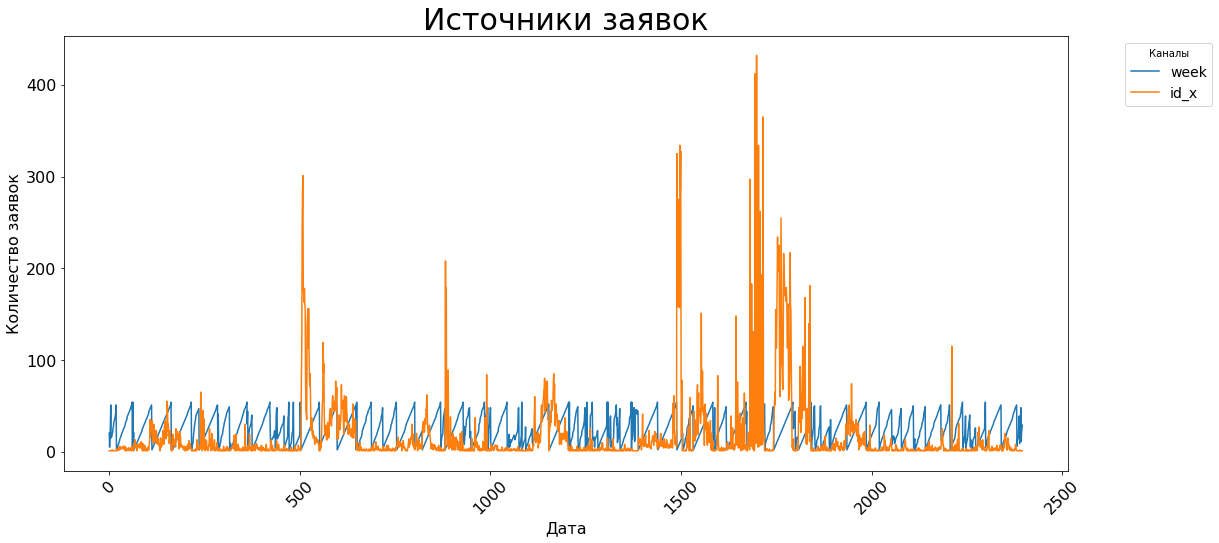

In [21]:
#noname = dr.pivot_table(index='dt',columns='source_x',values='id_x',aggfunc={'count'})
noname = dr.groupby(['product_type','source_x','week'],as_index=False).agg({'id_x':'count'})

noname.plot(figsize=(18,8),fontsize=16)
plt.title('Источники заявок',fontsize=30)
plt.xlabel('Дата',fontsize=16)
plt.ylabel('Количество заявок',fontsize=16)
plt.xticks(rotation=45)
plt.legend(title='Каналы', bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=14)
plt.savefig('Downloads/источники заявок.png',bbox_inches='tight')
plt.show()
#noname.to_excel('Источники заявок по каналам.xlsx')

In [22]:
noname.to_excel('Еженедельная презентация/Источники Заявок.xlsx')
import gspread
from gspread_dataframe import set_with_dataframe
# Доступ к GS
gc = gspread.service_account('voltaic-syntax-302214-e18198d5466a.json')
sh = gc.open_by_key('1W8_XtZaL8xqX1y_pVLN5dCM-zToXKzU3sMuYUT7JYak')
worksheet = sh.get_worksheet(13) #-> 0 - лист один, 1 - второй и тд.

# Выбор датафрейма
df1 = pd.read_excel('Еженедельная презентация/Источники Заявок.xlsx')
set_with_dataframe(worksheet, df1) 

In [23]:
noname[noname['source_x']=='Tele2 // Микрозаймы']

,product_type,source_x,week,id_x
364,CASH_LOAN,Tele2 // Микрозаймы,3,1
365,CASH_LOAN,Tele2 // Микрозаймы,13,7
366,CASH_LOAN,Tele2 // Микрозаймы,17,3
367,CASH_LOAN,Tele2 // Микрозаймы,21,3
368,CASH_LOAN,Tele2 // Микрозаймы,26,19
369,CASH_LOAN,Tele2 // Микрозаймы,27,9
370,CASH_LOAN,Tele2 // Микрозаймы,28,2
371,CASH_LOAN,Tele2 // Микрозаймы,30,4
372,CASH_LOAN,Tele2 // Микрозаймы,31,1
373,CASH_LOAN,Tele2 // Микрозаймы,35,2


In [24]:
dr1  =dr[dr['source_x']=='Мобильное приложение 1']
dr1['product_name'].unique()

array(['Лёгкий кредит', 'Кредит наличными', 'Кредит под залог квартиры',
       'Кредит под залог недвижимости', 'Рефинансирование от РОСБАНКА',
       'Потребительский', 'MoneyMan', 'Простой и удобный',
       'Деньги на карту', ' До Зарплаты', 'Ипотека от Совкомбанка',
       'Народный Кредит', 'МигКредит', '120 дней без платежей',
       'Турбозайм', '100 дней без %  Classic от Альфа-Банка', 'Деньга',
       'Opencard ', 'Pay P.S.', 'Рефинансирование',
       'Рефинансирование от УБРиР', 'Деньги на банковскую карту от Vivus',
       'VIVA деньги', 'Деньги на вашу карту от Kviku.ru',
       'Карта рассрочки Свобода от Home Credit',
       'Рефинансирование от Промсвязьбанка',
       'Кредитная карта от Восточный банк',
       'Рефинансирование от СКБ-Банка', 'Открытие 120 дней без платежей',
       'Тинькофф Platinum ', 'Умная карта',
       'Кредитная карта «Выгода» без визита в банк',
       'Карта рассрочки Халва от Совкомбанка', 'Zaymigo',
       'Ипотека от Банка "ФК Открытие"',

In [25]:
dr1[dr1['product_type']=='LOAN'].groupby(['week','partner','status_x']).agg({'userId':'count'})

userId
week partner        status_x        
6    MoneyMan       REJECTED       1
7    MoneyMan       REJECTED       1
8    Kviku.ru       REJECTED       1
     MoneyMan       ACCEPTED       2
                    REJECTED       1
     До Зарплаты    ACCEPTED       1
9    MoneyMan       ACCEPTED       1
                    REJECTED       1
     До Зарплаты    REJECTED       1
     МигКредит      ACCEPTED       1
10   MoneyMan       REJECTED       7
     Деньга         REJECTED       1
     Турбозайм      ACCEPTED       1
11   MoneyMan       REJECTED       1
     Pay P.S.       REJECTED       1
     VIVA деньги    APPROVED       1
     МигКредит      ACCEPTED       1
13   MoneyMan       ACCEPTED       1
     Zaymigo        REJECTED       1
14   MoneyMan       REJECTED       2
     Pay P.S.       REJECTED       1
15   MoneyMan       ACCEPTED       2
                    REJECTED       5
     VIVA деньги    APPROVED       1
     До Зарплаты    REJECTED       1
17    Vivus         REJECTED       1
     MoneyMan       ACCEPTED       1
                    REJECTED       3
     До Зарплаты    REJECTED       1
     МигКредит      APPROVED       1
18   MoneyMan       ACCEPTED       1
                    REJECTED       2
     Доброзайм      APPROVED       1
     МигКредит      ACCEPTED       1
20   MoneyMan       ACCEPTED       1
21   MoneyMan       ACCEPTED       3
                    REJECTED       2
     Займер         APPROVED       1
22   Konga          ACCEPTED       1
     MoneyMan       ACCEPTED       6
                    REJECTED       5
     Pay P.S.       REJECTED       2
     Срочноденьги   APPROVED       1
23    Vivus         REJECTED       1
     Fanmoney       REJECTED       2
     MoneyMan       ACCEPTED       2
                    REJECTED       1
     Pay P.S.       REJECTED       3
     Platiza        REJECTED       1
     VIVA деньги    APPROVED       1
     Zaimon         REJECTED       1
24   MoneyMan       ACCEPTED       1
                    REJECTED       4
     Pay P.S.       REJECTED       1
25   Fanmoney       REJECTED       1
     MoneyMan       ACCEPTED       2
                    REJECTED       1
     Pay P.S.       REJECTED       2
     Деньга         REJECTED       1
26   Fanmoney       REJECTED       2
     MoneyMan       ACCEPTED       2
                    REJECTED       4
     VIVA деньги    APPROVED       1
     До Зарплаты    APPROVED       1
     Турбозайм      APPROVED       1
27   MoneyMan       REJECTED       8
     VIVA деньги    APPROVED       1
     Быстроденьги   ACCEPTED       1
     Займер         APPROVED       1
28   CashToYou      APPROVED       1
     Fanmoney       REJECTED       1
     MoneyMan       REJECTED       1
     Zaimon         REJECTED       1
     Турбозайм      ACCEPTED       1
29   MoneyMan       REJECTED       3
30   MoneyMan       REJECTED       3
     VIVA деньги    APPROVED       1
     Быстроденьги   ACCEPTED       1
     МигКредит      ACCEPTED       1
31   Fanmoney       REJECTED       1
     MoneyMan       ACCEPTED       1
32   CreditPlus     APPROVED       1
     Деньги Сразу   APPROVED       1
33   MoneyMan       REJECTED       1
34   MoneyMan       REJECTED       2
     Webbankir      REJECTED       1
     Быстроденьги   APPROVED       1
     Доброзайм      APPROVED       1
                    REJECTED       1
35    Vivus         REJECTED       2
     MoneyMan       REJECTED       4
     До Зарплаты    APPROVED       1
     Честный займ   REJECTED       1
36   GreenMoney     REJECTED       1
     MoneyMan       REJECTED       2
     Webbankir      APPROVED       1
     Zaymigo        REJECTED       1
     Быстроденьги   ACCEPTED       1
     Займер         APPROVED       1
                    REJECTED       1
     СМСФинанс      ACCEPTED       1
     Хорошие деньги REJECTED       1
37   CreditPlus     APPROVED       1
     Max.Credit     REJECTED       1
     MoneyMan       REJECTED       1
     Быстроденьги   ACCEPTED       1
     СМСФинанс      ACCEPTED      

In [26]:
loan = dr1[dr1['product_type']=='LOAN']
loan.pivot_table(index='sourceGlobal_y',columns=['week','status_x'],values='userId_x',aggfunc='count')

week                 6        7        8                 9                 10                11                         13                14       15                         17                         18                         20       21                         22                         23                         24                25                26                         27                         28                         29       30                         31                32       33       34                35                36                         37                         38                39                41                42                         43       44                45                         46                         47                       48                49                         50                         51                  
status_x       REJECTED REJECTED ACCEPTED REJECTED ACCEPTED REJECTED ACCEPTED REJECTED ACCEPTED APPROVED REJECTED ACCEPTED REJECTED REJECTED ACCEPTED APPROVED REJECTED ACCEPTED APPROVED REJECTED ACCEPTED APPROVED REJECTED ACCEPTED ACCEPTED APPROVED REJECTED ACCEPTED APPROVED REJECTED ACCEPTED APPROVED REJECTED ACCEPTED REJECTED ACCEPTED REJECTED ACCEPTED APPROVED REJECTED ACCEPTED APPROVED REJECTED ACCEPTED APPROVED REJECTED REJECTED ACCEPTED APPROVED REJECTED ACCEPTED REJECTED APPROVED REJECTED APPROVED REJECTED APPROVED REJECTED ACCEPTED APPROVED REJECTED ACCEPTED APPROVED REJECTED APPROVED REJECTED ACCEPTED REJECTED ACCEPTED REJECTED ACCEPTED APPROVED REJECTED REJECTED ACCEPTED REJECTED ACCEPTED APPROVED REJECTED ACCEPTED APPROVED REJECTED ACCEPTED ISSUED REJECTED ACCEPTED REJECTED ACCEPTED APPROVED REJECTED ACCEPTED APPROVED REJECTED ACCEPTED APPROVED REJECTED
sourceGlobal_y                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
Android_mobile      1.0      NaN      NaN      1.0      NaN      NaN      1.0      4.0      NaN      1.0      2.0      1.0      1.0      NaN      1.0      1.0      4.0      NaN      1.0      4.0      2.0      1.0      1.0      NaN      1.0      NaN      1.0      4.0      NaN      1.0      1.0      1.0      5.0      NaN      3.0      2.0      3.0      1.0      1.0      4.0      NaN      1.0      6.0      NaN      1.0      1.0      1.0      2.0      NaN      1.0      NaN      1.0      NaN      NaN      1.0      2.0      1.0      4.0      2.0      2.0      5.0      1.0      1.0      2.0      1.0      2.0      1.0      NaN      1.0      1.0      1.0      1.0      2.0      NaN      NaN      1.0      1.0      NaN      NaN      NaN      NaN      NaN      NaN    NaN      6.0      4.0      2.0      7.0      NaN      4.0      6.0      NaN      6.0      7.0      NaN      5.0
Apple_mobile        NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      1.0      NaN      1.0 

In [27]:
loan.groupby(['week','partner','type','status_x']).agg({'userId_x':'count'})

userId_x
week partner        type status_x          
6    MoneyMan       API  REJECTED         1
7    MoneyMan       API  REJECTED         1
8    Kviku.ru       API  REJECTED         1
     MoneyMan       API  ACCEPTED         2
                         REJECTED         1
     До Зарплаты    LINK ACCEPTED         1
9    MoneyMan       API  ACCEPTED         1
                         REJECTED         1
     До Зарплаты    LINK REJECTED         1
     МигКредит      LINK ACCEPTED         1
10   MoneyMan       API  REJECTED         7
     Деньга         LINK REJECTED         1
     Турбозайм      LINK ACCEPTED         1
11   MoneyMan       API  REJECTED         1
     Pay P.S.       LINK REJECTED         1
     VIVA деньги    LINK APPROVED         1
     МигКредит      LINK ACCEPTED         1
13   MoneyMan       API  ACCEPTED         1
     Zaymigo        LINK REJECTED         1
14   MoneyMan       API  REJECTED         2
     Pay P.S.       LINK REJECTED         1
15   MoneyMan       API  ACCEPTED         1
                         REJECTED         5
                    LINK ACCEPTED         1
     VIVA деньги    LINK APPROVED         1
     До Зарплаты    LINK REJECTED         1
17    Vivus         LINK REJECTED         1
     MoneyMan       API  ACCEPTED         1
                         REJECTED         3
     До Зарплаты    LINK REJECTED         1
     МигКредит      LINK APPROVED         1
18   MoneyMan       API  ACCEPTED         1
                         REJECTED         2
     Доброзайм      LINK APPROVED         1
     МигКредит      LINK ACCEPTED         1
20   MoneyMan       API  ACCEPTED         1
21   MoneyMan       API  ACCEPTED         3
                         REJECTED         2
     Займер         LINK APPROVED         1
22   Konga          LINK ACCEPTED         1
     MoneyMan       API  ACCEPTED         6
                         REJECTED         5
     Pay P.S.       LINK REJECTED         2
     Срочноденьги   LINK APPROVED         1
23    Vivus         LINK REJECTED         1
     Fanmoney       LINK REJECTED         2
     MoneyMan       API  ACCEPTED         2
                         REJECTED         1
     Pay P.S.       LINK REJECTED         3
     Platiza        LINK REJECTED         1
     VIVA деньги    LINK APPROVED         1
     Zaimon         LINK REJECTED         1
24   MoneyMan       API  ACCEPTED         1
                         REJECTED         4
     Pay P.S.       LINK REJECTED         1
25   Fanmoney       LINK REJECTED         1
     MoneyMan       API  ACCEPTED         2
                         REJECTED         1
     Pay P.S.       LINK REJECTED         2
     Деньга         LINK REJECTED         1
26   Fanmoney       LINK REJECTED         2
     MoneyMan       API  ACCEPTED         1
                         REJECTED         4
                    LINK ACCEPTED         1
     VIVA деньги    LINK APPROVED         1
     До Зарплаты    LINK APPROVED         1
     Турбозайм      LINK APPROVED         1
27   MoneyMan       API  REJECTED         8
     VIVA деньги    LINK APPROVED         1
     Быстроденьги   LINK ACCEPTED         1
     Займер         LINK APPROVED         1
28   CashToYou      LINK APPROVED         1
     Fanmoney       LINK REJECTED         1
     MoneyMan       API  REJECTED         1
     Zaimon         LINK REJECTED         1
     Турбозайм      LINK ACCEPTED         1
29   MoneyMan       API  REJECTED         3
30   MoneyMan       API  REJECTED         3
     VIVA деньги    LINK APPROVED         1
     Быстроденьги   LINK ACCEPTED         1
     МигКредит      LINK ACCEPTED         1
31   Fanmoney       LINK REJECTED         1
     MoneyMan       LINK ACCEPTED         1
32   CreditPlus     LINK APPROVED         1
     Деньги Сразу   LINK APPROVED         1
33   MoneyMan       API  REJECTED         1
34   MoneyMan       API  REJECTED         2
     Webbankir      LINK REJECTED         1
     Быстроденьги   LINK APPROVED         1
     Доброзайм      LINK APPROV

In [28]:
mob = dr1.groupby(['sourceGlobal_y','week','product_type'],as_index=False).agg({'id_x':'count'})
mob.to_excel('Еженедельная презентация/Воронка по мобильному приложению1.xlsx')
# Доступ к GS
gc = gspread.service_account('voltaic-syntax-302214-e18198d5466a.json')
sh = gc.open_by_key('1W8_XtZaL8xqX1y_pVLN5dCM-zToXKzU3sMuYUT7JYak')
worksheet = sh.get_worksheet(14) #-> 0 - лист один, 1 - второй и тд.

# Выбор датафрейма
df1 = pd.read_excel('Еженедельная презентация/Воронка по мобильному приложению1.xlsx')
set_with_dataframe(worksheet, df1) 

In [29]:
mob

,sourceGlobal_y,week,product_type,id_x
0,Android_mobile,5,CASH_LOAN,4
1,Android_mobile,5,REFINANCE,2
2,Android_mobile,6,LOAN,1
3,Android_mobile,8,CASH_LOAN,7
4,Android_mobile,8,LOAN,1
5,Android_mobile,9,CASH_LOAN,8
6,Android_mobile,9,CREDIT_CARD,1
7,Android_mobile,10,CASH_LOAN,2
8,Android_mobile,10,CREDIT_CARD,1
9,Android_mobile,10,LOAN,5


In [30]:
ded = dr1[dr1['product_type']=='DEBIT_CARD']
ded = ded[ded['week']==47]
ded[ded['status_x']!='NEW']

,_id,type,createdAt,updatedAt,status_x,borrower,partner,product,statusFields,adapterName,whence_x,clickId,id_x,dt,productId_x,product_type,product_name,userId_x,phone,requestId,indexName_x,fallbackResponse_x,json_x,id_y,eventType_x,source_x,params_x,timestamp_x,gaId_x,userId_y,utm_campaign_x,utm_medium_x,utm_source_x,utm_term_x,productType_x,yandexClientID_x,productId_y,whence_y,transitionId,partnerName,payout,status_y,transaction_id,externalId,orderId,transactionId,time_x,date,userId,utm_campaign_y,utm_medium_y,utm_content,utm_source_y,utm_term_y,gaId_y,yandexClientID_y,sourceGlobal_x,score,whence,medium,indexName_y,fallbackResponse_y,json_y,id,eventType_y,source_y,params_y,timestamp_y,gaId,utm_campaign,utm_medium,utm_source,utm_term,productType_y,yandexClientID,currentPage,sourceGlobal_y,time_y,dt_reg,currentPage1,currentPage2,month,week
35882,6195ee3df7925700015636fa,LINK,2021-11-18 06:10:05.138,2021-11-18 06:14:22.214,ACCEPTED,"{'_id': None, 'userId': '6195ec055a40230001f299c9', 'fullName': 'Помешкина Галина Николаевна', 'email': 'pomeshkina.galina@mail.ru', 'phone': '79777170443'}",Банк «Открытие»,"{'_id': 5f589c308993ec00016deb3c, 'name': 'Opencard', 'productType': 'DEBIT_CARD', 'productName': 'Дебетовая карта'}","{'LINK': None, 'NOTE': '2233'}",LEADGID_PARTNER,showcase,d8cccd8f-5bc7-415d-86e4-eb6f69a94783,6195ee3df7925700015636fa,2021-11-18,5f589c308993ec00016deb3c,DEBIT_CARD,Opencard,6195ec055a40230001f299c9,79777170443,NaN,NaN,NaN,NaN,NaN,NaN,Мобильное приложение 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,6195ec055a40230001f299c9,NaN,NaN,NaN,NaN,NaN,GA1.2.26336605.1637215247,1637215248530970198,NaN,75,showcase,showcase,None,False,"{""id"":""074c742d-0b6c-4da1-a441-014b4e791c47"",""eventType"":""REGISTRATION"",""timestamp"":""2021-11-18T06:04:31.192Z"",""source"":""public"",""indexName"":null,""params"":{""productType"":""cash"",""sourceGlobal"":""Android_mobile"",""sessionId"":""2bfe5d43-c7ba-4fcc-a78f-43514cb0368b"",""userId"":""6195ec055a40230001f299c9"",""gaId"":""1"",""yandexClientID"":""1637215248530970198"",""ipAddress"":""176.59.41.183""},""fallbackResponse"":false}",074c742d-0b6c-4da1-a441-014b4e791c47,REGISTRATION,public,"{'gaId': '1', 'sourceGlobal': 'Android_mobile', 'yandexClientID': '1637215248530970198', 'ipAddress': '176.59.41.183', 'sessionId': '2bfe5d43-c7ba-4fcc-a78f-43514cb0368b', 'userId': '6195ec055a40230001f299c9', 'productType': 'cash'}",2021-11-18T06:04:31.192Z,1,NaN,NaN,NaN,NaN,cash,1637215248530970198,NaN,Android_mobile,2021-11-18 06:04:31,2021-11-18,NaN,NaN,2021-11-November,47
36031,619835ce40bdd500018bec0e,LINK,2021-11-19 23:39:58.124,2021-12-19 23:57:20.356,REJECTED,"{'_id': None, 'userId': '6198338e5a40230001f3b6b4', 'fullName': 'Донюкова Елена Валерьевна', 'email': 'shpik0109@gmail.com', 'phone': '79151899089'}",Экспобанк,"{'_id': 604a26b88f74a300012c8722, 'name': 'Накопительная карта от Экспобанка', 'productType': 'DEBIT_CARD', 'productName': 'Дебетовая карта'}","{'NOTE': '5161', 'LINK': None}",LEADGID_PARTNER,showcase,38f78926-6973-49bc-9e45-fb64cf9cad0a,619835ce40bdd500018bec0e,2021-11-20,604a26b88f74a300012c8722,DEBIT_CARD,Накопительная карта от Экспобанка,6198338e5a40230001f3b6b4,79151899089,NaN,NaN,NaN,NaN,NaN,NaN,Мобильное приложение 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,6198338e5a40230001f3b6b4,NaN,NaN,NaN,NaN,NaN,GA1.2.1651711756.1637364634,NaN,NaN,75,showcase,showcase,None,False,"{""id"":""adeac069-26ce-4ece-b0a7-5c1f98a3a8fe"",""eventType"":""REGISTRATION"",""timestamp"":""2021-11-19T23:31:26.402Z"",""source"":""public"",""indexName"":null,""params"":{""productType"":""cash"",""sourceGlobal"":""Android_mobile"",""sessionId"":""246f682f-4105-4d58-90e4-880bb0895769"",""userId"":""6198338e5a40230001f3b6b4"",""gaId"":""1"",""ipAddress"":""37.73.145.162""},""fallbackResponse"":false}",adeac069-26ce-4ece-b0a7-5c1f98a3a8fe,REGISTRATION,public,"{'ipAddress': '37.73.145.162', 'sessionId':

In [31]:
mob1 = mob[mob['week']== 50]

In [32]:
mob1

,sourceGlobal_y,week,product_type,id_x
181,Android_mobile,50,CASH_LOAN,20
182,Android_mobile,50,CREDIT_CARD,9
183,Android_mobile,50,LOAN,12
184,Android_mobile,50,REFINANCE,2
256,Apple_mobile,50,CASH_LOAN,35
257,Apple_mobile,50,CREDIT_CARD,22
258,Apple_mobile,50,LOAN,15
259,Apple_mobile,50,REFINANCE,1
421,Huawei_mobile,50,CASH_LOAN,8
422,Huawei_mobile,50,CREDIT_CARD,4


In [33]:
dr1['week_day'] = dr1['dt'].dt.dayofweek

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
dr1 = dr1[dr1['week']== 50]
dr1

,_id,type,createdAt,updatedAt,status_x,borrower,partner,product,statusFields,adapterName,whence_x,clickId,id_x,dt,productId_x,product_type,product_name,userId_x,phone,requestId,indexName_x,fallbackResponse_x,json_x,id_y,eventType_x,source_x,params_x,timestamp_x,gaId_x,userId_y,utm_campaign_x,utm_medium_x,utm_source_x,utm_term_x,productType_x,yandexClientID_x,productId_y,whence_y,transitionId,partnerName,payout,status_y,transaction_id,externalId,orderId,transactionId,time_x,date,userId,utm_campaign_y,utm_medium_y,utm_content,utm_source_y,utm_term_y,gaId_y,yandexClientID_y,sourceGlobal_x,score,whence,medium,indexName_y,fallbackResponse_y,json_y,id,eventType_y,source_y,params_y,timestamp_y,gaId,utm_campaign,utm_medium,utm_source,utm_term,productType_y,yandexClientID,currentPage,sourceGlobal_y,time_y,dt_reg,currentPage1,currentPage2,month,week,week_day
37663,61ad9e13f79257000156b3b4,LINK,2021-12-06 05:22:27.892,2021-12-06 05:32:21.075,ACCEPTED,"{'_id': None, 'userId': '61ad9c31e6086b00019b683d', 'fullName': 'Шуменков Алексей Александрович', 'email': 'sumenkov@318mail.ru', 'phone': '79532587233'}",Тинькофф Банк,"{'_id': 5ab9f4a121f7ea000743497f, 'name': 'Кредит наличными', 'productType': 'CASH_LOAN', 'productName': 'Кредит наличными'}","{'LINK': None, 'NOTE': '2275'}",,showcase,ba5d30d3-8d77-4303-804d-c742b3ccb5fc,61ad9e13f79257000156b3b4,2021-12-06,5ab9f4a121f7ea000743497f,CASH_LOAN,Кредит наличными,61ad9c31e6086b00019b683d,79532587233,NaN,NaN,NaN,NaN,NaN,NaN,Мобильное приложение 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,61ad9c31e6086b00019b683d,NaN,NaN,NaN,NaN,NaN,GA1.2.1752187647.1638782026,163878202731289973,NaN,15,showcase,showcase,None,False,"{""id"":""0024c3b9-715e-4ad7-aa5f-06bf7261c78d"",""eventType"":""REGISTRATION"",""timestamp"":""2021-12-06T05:17:14.897Z"",""source"":""public"",""indexName"":null,""params"":{""productType"":""cash"",""sourceGlobal"":""Android_mobile"",""sessionId"":""1e5c51b7-01a6-4733-b644-0e4529231b0b"",""userId"":""61ad9c31e6086b00019b683d"",""gaId"":""1"",""yandexClientID"":""163878202731289973"",""ipAddress"":""176.59.136.197""},""fallbackResponse"":false}",0024c3b9-715e-4ad7-aa5f-06bf7261c78d,REGISTRATION,public,"{'gaId': '1', 'sourceGlobal': 'Android_mobile', 'yandexClientID': '163878202731289973', 'ipAddress': '176.59.136.197', 'sessionId': '1e5c51b7-01a6-4733-b644-0e4529231b0b', 'userId': '61ad9c31e6086b00019b683d', 'productType': 'cash'}",2021-12-06T05:17:14.897Z,1,NaN,NaN,NaN,NaN,cash,163878202731289973,NaN,Android_mobile,2021-12-06 05:17:14,2021-12-06,NaN,NaN,2021-12-December,50,0
37664,61ada534a0c490000158a022,LINK,2021-12-06 05:52:52.814,2021-12-06 06:03:05.173,ACCEPTED,"{'_id': None, 'userId': '61ada43beae5be0001f8a2d6', 'fullName': 'Кадочникова Александра Андреевна', 'email': 'kadochnikova-199904@mail.ru', 'phone': '79831947861'}",Тинькофф Банк,"{'_id': 5b2250f1ec48160008759fc3, 'name': 'Кредитная карта Тинькофф Platinum', 'productType': 'CREDIT_CARD', 'productName': 'Кредитная карта'}","{'LINK': None, 'NOTE': 'OfferId not found'}",,showcase,9c7da251-2e64-4b81-98ae-1e36d37c5162,61ada534a0c490000158a022,2021-12-06,5b2250f1ec48160008759fc3,CREDIT_CARD,Кредитная карта Тинькофф Platinum,61ada43beae5be0001f8a2d6,79831947861,NaN,NaN,NaN,NaN,NaN,NaN,Мобильное приложение 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,61ada43beae5be0001f8a2d6,NaN,NaN,NaN,NaN,NaN,GA1.2.867949378.1638769728,16387697291060627342,NaN,1,showcase,showcase,None,False,"{""id"":""8e333acb-2d01-42de-8e5a-a9957ff937fe"",""eventType"":""REGISTRATION"",""timestamp"":""2021-12-06T05:50:26.584Z"",""source"":""public"",""indexName"":null,""params"":{""productType"":""cash"",""sourceGlobal"":""Apple_mobile"",""sessionId"":""56dfec13-9ade-457a-8b96-96e88d20e387"",""userId"":""61ada43beae5be0001f8a2d6"",""gaId"":""GS1.1.1638769727.1.1.1638769735.0"",""yandexClientID"":""16387697291060627342"",""ipAddress"":""213.87.126.2""},""fallbackRespons